### 1. Import dependecies

In [144]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional,Dict

### 2. Load data

In [145]:
df = pd.read_csv('../data/processed/countries_pca_4components.csv')
X = df[['pc_1', 'pc_2', 'pc_3', 'pc_4']].values

### 3. Helper functions

In [146]:
def pairwise_distances_sq(X: np.ndarray) -> np.ndarray:
    n = X.shape[0]
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                D[i, j] = np.sum((X[i] - X[j]) ** 2)
    return D

def Hbeta(D: np.ndarray, beta: float) -> Tuple[float, np.ndarray]:
    P = np.exp(-D * beta)
    sumP = np.sum(P)
    if sumP == 0:
        return 0, np.zeros_like(D)
    P = P / sumP
    H = -np.sum(P * np.log(P + 1e-12))
    return H, P

def binary_search_beta(D_row: np.ndarray, target_perp: float) -> np.ndarray:
    D_row = D_row[D_row > 0]
    if len(D_row) == 0: return np.array([])
    beta, beta_min, beta_max = 1.0, 0, np.inf
    for _ in range(50):
        H, P = Hbeta(D_row, beta)
        perp = np.exp(H)
        if np.abs(perp - target_perp) < 1e-5: break
        if perp > target_perp:
            beta_min = beta
            beta = beta * 2 if beta_max == np.inf else (beta + beta_max)/2
        else:
            beta_max = beta
            beta = (beta + beta_min)/2
    return P

def compute_P_matrix(X: np.ndarray, perplexity: float) -> np.ndarray:
    n = X.shape[0]
    D = pairwise_distances_sq(X)
    P = np.zeros((n, n))
    for i in range(n):
        P_row = binary_search_beta(D[i], perplexity)
        if len(P_row) > 0:
            valid = D[i] > 0
            P[i, valid] = P_row
    P = (P + P.T) / (2 * n)
    P = P / np.sum(P)
    return P

### 4. t-SNE Implementation

In [147]:
def run_tsne(X: np.ndarray, perplexity=30, n_iter=1000, lr=200) -> np.ndarray:
    n = X.shape[0]
    P = compute_P_matrix(X, perplexity)
    Y = np.random.normal(0, 1e-4, (n, 2))

    for it in range(n_iter):
        D = pairwise_distances_sq(Y)
        Q = 1 / (1 + D)
        np.fill_diagonal(Q, 0)
        Q = Q / np.sum(Q)
        diff = Y[:, np.newaxis, :] - Y[np.newaxis, :, :]
        grad = np.zeros_like(Y)
        for i in range(n):
            for j in range(n):
                if i != j:
                    grad[i] += 4 * (P[i, j] - Q[i, j]) * Q[i, j] * (Y[i] - Y[j])
        Y -= lr * grad
        if it % 100 == 0:
            print(f"Iteration {it}/{n_iter}")
    print("✅ t-SNE completed.")
    return Y

### 5. Run t-SNE & Save

In [148]:
perplexity = 30
learning_rate = 100
iterations = 1000

Y = run_tsne(X, perplexity=perplexity, n_iter=iterations, lr=learning_rate)

# Ensure output folders exist
os.makedirs("../data/processed", exist_ok=True)
os.makedirs("../artifacts/figures", exist_ok=True)

# Save final dataset
tsne_df = pd.DataFrame(Y, columns=['tsne_1', 'tsne_2'])
tsne_df.to_csv("../data/processed/best_tsne_dataset.csv", index=False)
print("✅ Best t-SNE dataset saved to '../data/processed/best_tsne_dataset.csv'")


Iteration 0/1000
Iteration 100/1000
Iteration 200/1000
Iteration 300/1000
Iteration 400/1000
Iteration 500/1000
Iteration 600/1000
Iteration 700/1000
Iteration 800/1000
Iteration 900/1000
✅ t-SNE completed.
✅ Best t-SNE dataset saved to '../data/processed/best_tsne_dataset.csv'


### 6. Plot & Save Figure

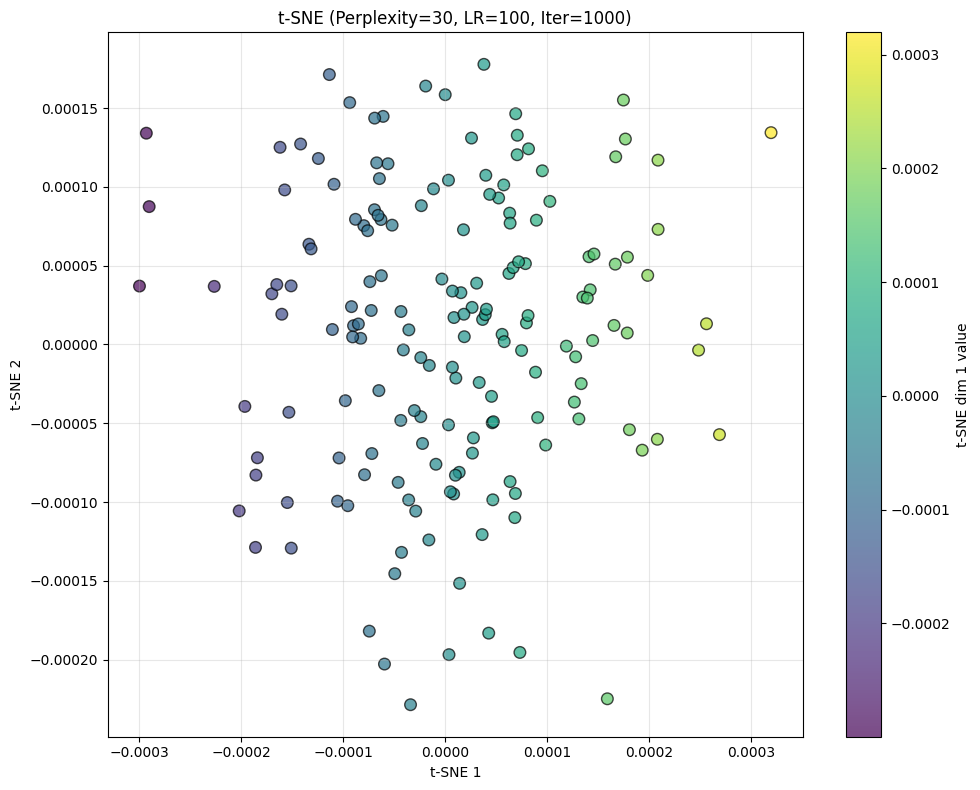

✅ Figure saved to '../artifacts/figures/tsne_clusters.png'


In [149]:
plt.figure(figsize=(10, 8))
plt.scatter(Y[:, 0], Y[:, 1], c=Y[:, 0], cmap='viridis', s=70, alpha=0.7, edgecolor='k')
plt.title(f"t-SNE (Perplexity={perplexity}, LR={learning_rate}, Iter={iterations})")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True, alpha=0.3)
plt.colorbar(label='t-SNE dim 1 value')
plt.tight_layout()

plt.savefig("../artifacts/figures/tsne_clusters.png", dpi=300)
plt.show()
print("✅ Figure saved to '../artifacts/figures/tsne_clusters.png'")